In [1]:
# Install required libraries
!pip install opencv-python-headless matplotlib scikit-learn tensorflow


In [2]:
# Upload the kaggle.json API key
from google.colab import files
files.upload()  # Upload kaggle.json

# Setup Kaggle API and download dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
# Download the specific dataset
!kaggle datasets download -d vuppalaadithyasairam/bone-fracture-detection-using-xrays
!unzip -q bone-fracture-detection-using-xrays.zip -d bone_xray_data

Dataset URL: https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays
License(s): unknown


In [4]:
import os

for root, dirs, files in os.walk("bone_xray_data"):
    print(root, len(files))


bone_xray_data 0
bone_xray_data/archive (6) 0
bone_xray_data/archive (6)/val 0
bone_xray_data/archive (6)/val/not fractured 240
bone_xray_data/archive (6)/val/fractured 360
bone_xray_data/archive (6)/train 0
bone_xray_data/archive (6)/train/not fractured 4383
bone_xray_data/archive (6)/train/fractured 4480


## **Preprocessing Pipeline (with Filtering + Segmentation)**
This pipeline now simulates medical image preprocessing steps commonly used before feeding to classifiers:

**Filtering:** to reduce noise

**Segmentation:** to extract edges of the bone

Then classification via CNN.


In [5]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 224

# Preprocessing: filtering + segmentation
def preprocess_image(img):
    # Apply Gaussian filter (noise reduction)
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply Canny edge detection (segmentation)
    img = cv2.Canny(img, threshold1=50, threshold2=150)

    # Resize and normalize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

# Load and preprocess all images
def load_images_with_preprocessing(path):
    images, labels = [], []
    class_map = {'fractured': 1, 'not fractured': 0}

    for cls in class_map:
        folder = os.path.join(path, cls)
        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = preprocess_image(img)
                images.append(img)
                labels.append(class_map[cls])

    return np.array(images), np.array(labels)

# Load training and validation data with filtering + segmentation
X_train, y_train = load_images_with_preprocessing("bone_xray_data/archive (6)/train")
X_val, y_val = load_images_with_preprocessing("bone_xray_data/archive (6)/val")

# Normalize and reshape
X_train = X_train / 255.0
X_val = X_val / 255.0
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# One-hot encode labels
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)


## **Step 2: CNN Model**

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,074 (91.20 MB)

 Trainable params: 23,907,074 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

## **Step 3: Train the Model**



In [7]:
history = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=10, batch_size=32)


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.7159 - loss: 0.5767 - val_accuracy: 0.6050 - val_loss: 1.0325
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.9678 - loss: 0.1021 - val_accuracy: 0.6050 - val_loss: 1.4530
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9912 - loss: 0.0294 - val_accuracy: 0.5917 - val_loss: 2.0622
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9950 - loss: 0.0137 - val_accuracy: 0.5867 - val_loss: 2.3878
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9956 - loss: 0.0145 - val_accuracy: 0.5967 - val_loss: 2.7844
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.9976 - loss: 0.0089 - val_accuracy: 0.6067 - val_loss: 3.1593
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9975 - loss: 0.0076 - val_accuracy: 0.5717 - val_loss: 3.2351
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9961 - loss: 0.0128 - 

## **Step 4: Evaluate & Visualize**

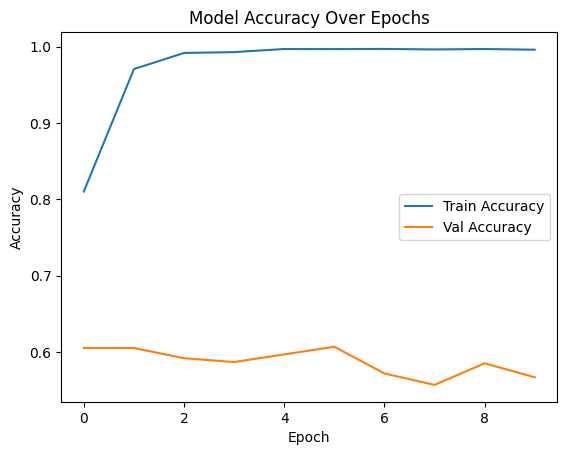

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6239 - loss: 1.6391

Validation Accuracy: 0.57
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.46      0.43      0.44       240
    Fractured       0.63      0.66      0.65       360

     accuracy                           0.57       600
    macro avg       0.54      0.54      0.54       600
 weighted avg       0.56      0.57      0.56       600



In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val_cat)
print(f"\nValidation Accuracy: {val_acc:.2f}")

# Predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes, target_names=['Not Fractured', 'Fractured']))


## **Step 5: Save the Model**
Use model.save() to store it in .h5 format:

In [9]:
model.save("fracture_cnn_model.h5")


## **Reload the Model Anytime**
Later, even in a new notebook or script:

In [10]:
from tensorflow.keras.models import load_model

model = load_model("fracture_cnn_model.h5")


## **Last Step: Single Image Prediction (e.g., test image)**



In [11]:
import cv2
import numpy as np

def predict_fracture(img_path):
    # Load in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Check if image loaded successfully
    if img is None:
        print(f"Error: Could not load image at path: {img_path}")
        return  # Exit the function if image loading failed

    # Apply the same preprocessing: filter + segment + resize
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.Canny(img, 50, 150)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normalize and reshape
    img = img / 255.0
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

    # Predict
    pred = model.predict(img)
    class_idx = np.argmax(pred)

    classes = ['Not Fractured', 'Fractured']
    print(f"Prediction: {classes[class_idx]} (Confidence: {pred[0][class_idx]:.2f})")

In [13]:
predict_fracture("/content/4-rotated3-rotated2-rotated1.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Not Fractured (Confidence: 1.00)
